In [ ]:
!pip install -qU transformers

# Mask Generation

**Mask generation** is the task of generating semantically meaningful masks for an image. This is similar to image segmentation but image segmentation models are trained on labeled datasets and are limited to the classes they have seen during training.

Mask generation models are trained on large amounts of data and operate in two modes:
* **Prompting mode**: the model takes in an image and a prompt, where a prompt can be a 2D point location (XY coordinates) in the image within an object or a bounding box surrounding an object. In prompting mode, the model only returns the mask over the object that the prompt is pointing out.
* **Segment-everything mode**: the model generates every mask in a given image. To do so, a grid of points is generated and overlaid on the image for inference.

Mask generation is supported by **Segment Anything Model (SAM)**, which consists of a Vision Transformer-based image encoder, a prompt encoder, and a two-way transformer mask decoder. Images and prompts are encoded, and the decoder takes these embeddings and generates valid masks.

## Mask generation pipeline

In [1]:
from transformers import pipeline

checkpoint = 'facebook/sam-vit-base'
mask_generator = pipeline(
    model=checkpoint,
    task='mask-generation'
)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cuda:0


In [2]:
# load an image
from PIL import Image
import requests

img_url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/bee.jpg"
image = Image.open(requests.get(img_url, stream=True).raw)
image = image.convert("RGB")
image

Output hidden; open in https://colab.research.google.com to view.

Let's segment everything first.

the `points-per-batch` enables parallel inference of points in segment everything mode. This enables faster inference, but consumes more memory. In addition, SAM only enables batching over points and not the images. The `pred_iou_thresh` is the IoU confidence threshold where only the masks above that certain threshold are returned:

In [ ]:
masks = mask_generator(
    image,
    points_per_batch=128,
    pred_iou_thresh=0.88,
)

In [ ]:
masks

In [ ]:
# visualize the masks
import matplotlib.pyplot as plt

plt.imshow(image, cmap='gray')

for i, mask in enumerate(masks['masks']):
    plt.imshow(
        mask,
        cmap='viridis',
        alpha=0.1,
        vmin=0,
        vmax=1
    )

plt.axis('off')
plt.show()

## Model inference

### Point prompting

In [4]:
from transformers import SamModel, SamProcessor
import torch
from accelerate.test_utils.testing import get_backend

device, _, _ = get_backend()
model = SamModel.from_pretrained(checkpoint).to(device)
processor = SamProcessor.from_pretrained(checkpoint)

To do point prompting, we can pass the input point to the processor, then take the processor output and pass it to the model for inference. To post-process the model output, we can pass the outputs and `original_sizes` and `reshaped_input_sizes` we take from the processor's initial output. We need to pass these since the processor resizes the image, and the output needs to be extrapolated.

In [5]:
# Point location of the bee
input_points = [[[2592, 1728]]]

inputs = processor(
    image,
    input_points=input_points,
    return_tensors='pt'
).to(device)

with torch.no_grad():
    outputs = model(**inputs)

masks = processor.image_processor.post_process_masks(
    outputs.pred_masks.cpu(),
    inputs['original_sizes'].cpu(),
    inputs['reshaped_input_sizes'].cpu()
)

/usr/local/lib/python3.11/dist-packages/transformers/image_processing_utils.py:42: UserWarning: The following named arguments are not valid for `SamImageProcessor.preprocess` and were ignored: 'point_pad_value'
  return self.preprocess(images, **kwargs)


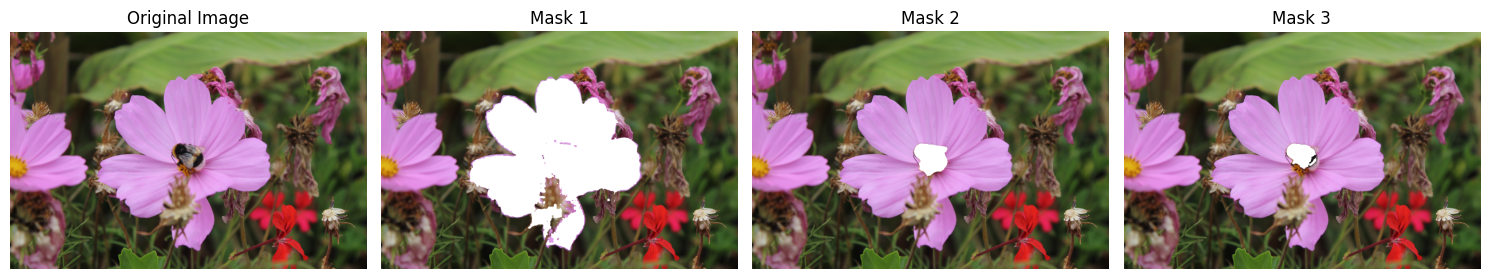

In [6]:
# visualize the masks
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 4, figsize=(15, 5))

axes[0].imshow(image)
axes[0].set_title('Original Image')
mask_list = [
    masks[0][0][0].numpy(), masks[0][0][1].numpy(), masks[0][0][2].numpy()
]

for i, mask in enumerate(mask_list, start=1):
    overlaid_image = np.array(image).copy()

    overlaid_image[:, :, 0] = np.where(mask == 1, 255, overlaid_image[:, :, 0])
    overlaid_image[:, :, 1] = np.where(mask == 1, 255, overlaid_image[:, :, 1])
    overlaid_image[:, :, 2] = np.where(mask == 1, 255, overlaid_image[:, :, 2])

    axes[i].imshow(overlaid_image)
    axes[i].set_title(f'Mask {i}')

for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()

### Box prompting

For box prompting, we can pass the input box in the format of a list `[x_min, y_min, x_max, y_max]` format along with the image to the `processor`. Take the processor output and directly pass it to the model, then post-process the output again.

In [7]:
# bounding box around the bee
box = [2350, 1600, 2850, 2100]

inputs = processor(
    image,
    input_boxes=[[[box]]],
    return_tensors='pt'
).to('cuda')

with torch.no_grad():
    outputs = model(**inputs)

mask = processor.image_processor.post_process_masks(
    outputs.pred_masks.cpu(),
    inputs['original_sizes'].cpu(),
    inputs['reshaped_input_sizes'].cpu()
)[0][0][0].numpy()

/usr/local/lib/python3.11/dist-packages/transformers/image_processing_utils.py:42: UserWarning: The following named arguments are not valid for `SamImageProcessor.preprocess` and were ignored: 'point_pad_value'
  return self.preprocess(images, **kwargs)


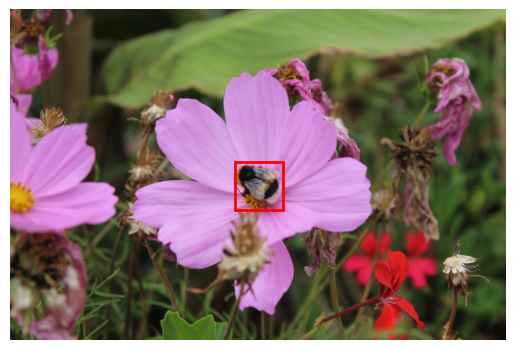

In [9]:
# visualize the bounding box
import matplotlib.patches as patches

fig, ax = plt.subplots()
ax.imshow(image)

rectangle = patches.Rectangle(
    (box[0], box[1]),
    box[2] - box[0],
    box[3] - box[1],
    linewidth=2,
    edgecolor='r',
    facecolor='none'
)
ax.add_patch(rectangle)
ax.axis('off')
plt.show()

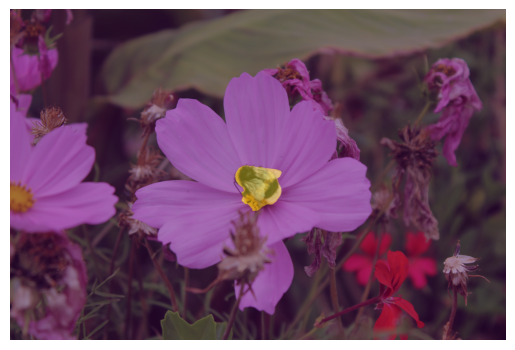

In [10]:
# visual the inference mask
fig, ax = plt.subplots()
ax.imshow(image)
ax.imshow(mask, cmap='viridis', alpha=0.4)
ax.axis('off')
plt.show()